In [5]:
import argparse
import sys
import matplotlib 
import random
#matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import gym
import envs
import pickle
#import gridworld_env
from gym import wrappers, logger
import numpy as np
import copy

Etant donné, que les données retournées par envx.getMDP() sont peu lisibles et moins facile a manipuler, on se propose de re-structurer des données. De sorte d'avoir un dictionnaire organiser de la façon suivante:
proba = {state's num : action's num : {next_state: proba}*}
rewards = {state's num : action's num : {next_state: reward}*}

In [6]:
#transformation
def transform(envx, norm=True):
    """return proba sous le format decrit plus haut et rewards
    """
    
    #version 1
    """    proba = {}
    for state_name, rest in envx.getMDP()[1].items():     
            actions = {}
            for action in rest.keys():
                transitions = {}   
                for p in rest[action]:
                    transitions[envx.getMDP()[0][p[1]]] = p[0]
                actions[action] = transitions
            proba[envx.getMDP()[0][state_name]] = actions
    """
    #version 2
    proba = { envx.getMDP()[0][state_name]: 
    { 
        action : 
        {
            envx.getMDP()[0][p[1]] :  
            p[0]  for p in rest[action] 
        } 
        for action in rest.keys()
    }
    for state_name, rest in envx.getMDP()[1].items()
   }
    #normalisation des probas
    if norm:
        #version 1
        for s in proba:
            for a in proba[s]:
                tmp = np.sum(list(proba[s][a].values()))
                for k, v in proba[s][a].items():
                    proba[s][a][k] = v/tmp         
        #vesrion 2
        #proba = {state: {a: {proba[state][a][s]: j/np.sum(list(proba[state][a].values())) 
        #     for s, j in proba[state][a].items()}for a in proba[state]}for state, v in proba.items()}
        #version 2               
    rewards = { envx.getMDP()[0][state_name]: 
    { 
        action : 
        {
            envx.getMDP()[0][p[1]] :  
            p[2]  for p in rest[action] 
        } 
        for action in rest.keys()
    }
    for state_name, rest in envx.getMDP()[1].items()
   }
    return proba, rewards

In [7]:
class PlicyIteration(object):
    
    def __init__(self, envx, plan, discount=1, eps=.0001, robot=2):
        self.eps = eps
        self.envx = envx
        self.robot = robot 
        self.plan = plan
        self.discount = discount
        self.policy_stable = False
        self.action_space = envx.action_space 
        self.proba, self.rewards = transform(envx)
        #self.values : dict mieux que array car ils manquent certains etats
        self.values = {state : 0 for state in envx.getMDP()[0].values()}
        # <!> les observations sont dans un fichier binaires,  sér
        self.observation_to_state = {str(pickle.loads(list(envx.getMDP()[0].keys())[state])): 
                        state  for state in envx.getMDP()[0].values()}
        actions_possibles = set([v for actions in envx.getMDP()[1].values() for v in list(actions.keys())])
        self.policy = {state : random.choice(list(actions_possibles)) for state in range(len(envx.getMDP()[0].values()))} 
        
    
    def check_policy(self, state):
        if state not in self.policy_dico.keys():
            #ce cas n'est pas arrivé
            self.policy_dico[state] = None
        return self.policy_dico[state]
    
    def get_state_value(self, current_state, action):
        return  np.sum([prob*(self.rewards[current_state][action][next_state] + \
        self.discount*self.values[next_state]) for next_state, prob in self.proba[current_state][action].items()])
        
    def policy_evaluation(self, nb_iter=100000):
        delta = np.inf
        while delta > self.eps and nb_iter:
            delta = 0
            for current_state in self.proba:
                v_old = self.values[current_state]
                action = self.policy[current_state]
                tmp = 0
                self.values[current_state]= self.get_state_value(current_state, action)
                delta = max(delta, abs(v_old - self.values[current_state]))      
            nb_iter -=1
            
    def best_action(self, current_state):
        values = [self.get_state_value(current_state, action) for action in self.proba[current_state]]
        action =  np.argmax(values)
        value = values[int(action)]
        return action
    
    def policy_improvement(self):
        self.policy_stable = True 
        for state in self.proba:
            current_action = self.policy[state]
            self.policy[state] = self.best_action(state)
            if current_action != self.policy[state]:
                self.policy_stable = False
                  
    def fit(self, nb_iter=1000): 
        
        while not self.policy_stable and nb_iter: 
            self.policy_evaluation()
            self.policy_improvement()
            nb_iter -=1


    def plt_values(self):
        grid_size = pickle.loads(list(self.envx.getMDP()[0].keys())[5]).shape
        self.grid = np.zeros(grid_size)
        
        for state_name, state_num in self.envx.getMDP()[0].items():
            state_serial = np.array(pickle.loads(state_name))
            x, y  = np.where(state_serial == self.robot)
            self.grid[x, y] = self.values[state_num]
        print(self.values)
        plt.title(str(self.plan))
        plt.imshow(self.grid / self.grid.max(), cmap ='gray')
        plt.show()
        

    def act(self, observation, reward, done):
        return self.policy[self.observation_to_state[str(observation)]]

In [11]:
outdir = 'gridworld-v0/random-agent-results'
envx = gym.make('gridworld-v0')
env = wrappers.Monitor(envx, directory=outdir, force=True, video_callable=False)
env.seed(0)
episode_count = 100
reward = 0
done = False
envx.verbose = True
plan =   {0: -3, 3: 1 , 4: -1, 5: -1, 6: -1}
envx.setPlan("gridworldPlans/plan0.txt", plan )

agent = PlicyIteration(envx, plan)
#np.random.seed(5)
agent.fit()
rsum=0

for i in range(episode_count):
    ob = env.reset()

    if i % 100 == 0 and i > 0:
        envx.verbose = True
    else:
        envx.verbose = False

    if envx.verbose:
            #envx.render(1)
            1
    j = 0
    #print(str(ob))
    while True:

        action = agent.act(ob, reward, done)
        ob, reward, done, _ = env.step(action)
        rsum+=reward
        j += 1
        if envx.verbose:
            #envx.render()
            1
        if done:
            #print(str(i)+" rsum="+str(rsum)+", "+str(j)+" actions")
            rsum=0
            break

print("done")
env.close()

#agent.plt_values()

['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
['1 1 1 1 1 1\n', '1 0 0 0 3 1\n', '1 0 1 0 5 1\n', '1 0 0 0 2 1\n', '1 1 1 1 1 1\n', '1 1 1 1 1 1']
done


{0: -2.163653366676953, 1: 0, 2: -5.472880299387934, 3: -1.9466957606131134, 4: 0.0059226932643687835, 5: 0, 6: -3.3690773067371693, 7: -7.540952308049711, 8: -10.915952308793802, 9: -12.411001021247987, 10: -8.847880299472694}


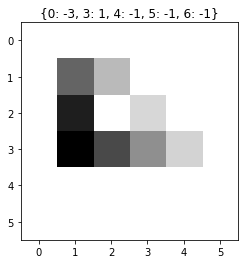

In [12]:
agent.plt_values()